# Лабораторная работа 2.4: Метод сращивания (пограничный слой)

## Формулировка задачи

Решение сингулярно возмущенного дифференциального уравнения второго порядка:

$$\varepsilon y'' + (2x+1) y' + 2y = 0, \quad x \in [0,1], \quad y(0)=A, \quad y(1)=B$$

где $\varepsilon \ll 1$ - малый параметр.

## Метод сращивания

При малом $\varepsilon$ решение имеет **пограничный слой** вблизи левой границы $x=0$, где производная резко меняется.

**Сращенное решение:**
$$y(x) = \frac{3B}{2x+1} + (A - 3B) \exp(-x/\varepsilon)$$

- Первое слагаемое: внешнее решение (регулярная часть)
- Второе слагаемое: пограничный слой (экспоненциально убывает при удалении от $x=0$)

## Численные методы

1. **Метод прогонки:** решение системы разностных уравнений
2. **SciPy solve_bvp:** метод решения краевых задач

## Анализ

Исследуется поведение решения в пограничном слое (ширина $\sim 5\varepsilon$) и сравнение сращенного решения с численными методами.


In [1]:
# 2.4 метод сращивания 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

#  ε y'' + (2x+1) y' + 2 y = 0,  x∈[0,1],  y(0)=A,  y(1)=B,  ε ≪ 1

def y_comp(x, eps, A, B):
    return 3.0 * B / (2.0 * x + 1.0) + (A - 3.0 * B) * np.exp(-x / eps)

# SciPy
def solve_scipy(eps, A, B, N=800):
    def ode_system(x, y):
        y1, y2 = y
        return np.vstack((
            y2,
            -((2.0 * x + 1.0) * y2 + 2.0 * y1) / eps
        ))

    def bc(ya, yb):
        return np.array([ya[0] - A, yb[0] - B])

    x = np.linspace(0.0, 1.0, N)
    y_guess = np.zeros((2, x.size))
    sol = solve_bvp(ode_system, bc, x, y_guess)
    return sol.x, sol.y[0]

def solve_progonka(eps, A, B, N=2000):
    x = np.linspace(0.0, 1.0, N + 1)
    dx = x[1] - x[0]

    a = np.zeros(N - 1)
    b = np.zeros(N - 1)
    c = np.zeros(N - 1)
    d = np.zeros(N - 1)

    for i in range(1, N):
        xi = x[i]
        Ai = eps / dx**2 - (2.0 * xi + 1.0) / (2.0 * dx)
        Bi = -2.0 * eps / dx**2 + 2.0
        Ci = eps / dx**2 + (2.0 * xi + 1.0) / (2.0 * dx)
        a[i - 1] = Ai
        b[i - 1] = Bi
        c[i - 1] = Ci
        d[i - 1] = 0.0

    # Учёт граничных условий y0=A, yN=B
    d[0] -= a[0] * A
    a[0] = 0.0
    d[-1] -= c[-1] * B
    c[-1] = 0.0

    # прогонка для внутренней системы (N-1 неизвестных: y1..y_{N-1})
    cp = np.zeros(N - 1)
    dp = np.zeros(N - 1)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, N - 1):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom # Venom =)

    y_inner = np.zeros(N - 1)
    y_inner[-1] = dp[-1]
    for i in range(N - 3, -1, -1):
        y_inner[i] = dp[i] - cp[i] * y_inner[i + 1]

    y = np.zeros(N + 1)
    y[0] = A
    y[-1] = B
    y[1:N] = y_inner

    return x, y


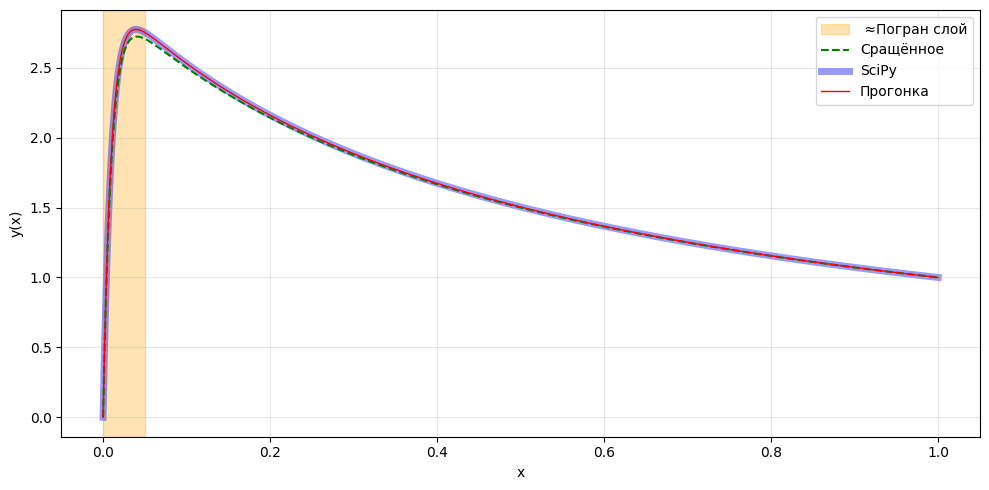

,x,compose,progonka,scipy,err(compose),err(progonka)
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,2.478610,2.537190,2.537076,0.058467,0.000114
2,0.05,2.707059,2.752565,2.752554,0.045495,0.000012
3,0.10,2.499864,2.530568,2.530569,0.030705,0.000001
4,0.30,1.875000,1.885787,1.885788,0.010788,0.000001
5,0.50,1.500000,1.504250,1.504251,0.004251,0.000001
6,0.80,1.153846,1.154707,1.154708,0.000861,0.000000
7,1.00,1.000000,1.000000,1.000000,0.000000,0.000000


In [2]:
A, B = 0.0, 1.0
EPS = 1e-2

x_sci, y_sci = solve_scipy(EPS, A, B)
x_num, y_num = solve_progonka(EPS, A, B, N=4000)

X = np.linspace(0.0, 1.0, 1000)
y_cmp = y_comp(X, EPS, A, B)

plt.figure(figsize=(10, 5))

# коридор, выделяющий пограничный слой
boundary_layer_width = 5 * EPS
plt.axvspan(0, boundary_layer_width, color='orange', alpha=0.3, zorder=0, label=f' ≈Погран слой')

# Графики решений
plt.plot(X, y_cmp, 'g--', zorder=2, label='Сращённое')
plt.plot(x_sci, y_sci, 'b-', linewidth=5, alpha=0.4, zorder=1, label='SciPy')
plt.plot(x_num, y_num, 'r-', linewidth=1, zorder=2, label='Прогонка')

plt.xlabel('x')
plt.ylabel('y(x)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

x_points = [0.0, 0.02, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0]
rows = []
for xv in x_points:
    rows.append({
        'x': xv,
        'compose': y_comp(xv, EPS, A, B),
        'progonka': float(np.interp(xv, x_num, y_num)),
        'scipy': float(np.interp(xv, x_sci, y_sci)),
    })

df = pd.DataFrame(rows)
df['err(compose)'] = np.abs(df['compose'] - df['scipy'])
df['err(progonka)'] = np.abs(df['progonka'] - df['scipy'])
display(df.round(6))
